In [37]:
import pgConn
import PostgresSQL_table_queries

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import ClousStorage as cs
import boto3

In [39]:
book_names = []

In [40]:
pg_conn = pgConn.PgConn(tablename="historical", dbname="cryptostocks", user="postgres")
pg_conn.init_db(PostgresSQL_table_queries.HISTORICAL_CRYPTO_STOCKS_TABLE_QUERY)
df = pg_conn.get_data(book_names)

Connection to the database successful!
Table created successfully!


In [41]:
df.head()

                         ref      book        date      open      high  \
0  https://finance.yahoo.com  tusd-btc  2023-08-09  0.000034  0.000034   
1  https://finance.yahoo.com  tusd-btc  2023-08-08  0.000034  0.000034   
2  https://finance.yahoo.com  tusd-btc  2023-08-07  0.000034  0.000034   
3  https://finance.yahoo.com  tusd-btc  2023-08-06  0.000034  0.000034   
4  https://finance.yahoo.com  tusd-btc  2023-08-05  0.000034  0.000034   

        low     close  adj_close  volume  
0  0.000034  0.000034   0.000034  102207  
1  0.000034  0.000034   0.000034   74850  
2  0.000034  0.000034   0.000034   34264  
3  0.000034  0.000034   0.000034   29283  
4  0.000034  0.000034   0.000034   78352  


In [43]:
import pandas as pd
# Convert the 'date' column to datetime data type
df['date'] = pd.to_datetime(df['date'])

# Check the data type of the 'date' column again
print(df['date'].dtype)

datetime64[ns]


In [44]:
selected_book = 'eth-usd'

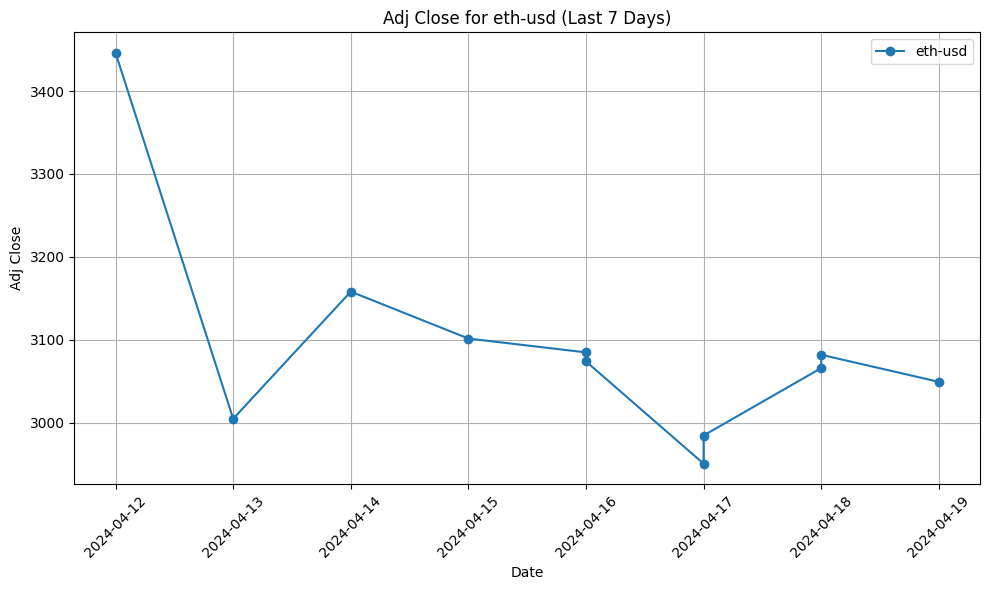

In [45]:
# Assume df is your DataFrame containing the data
# Filter the DataFrame to select data for the specified book
filtered_df = df[df['book'] == selected_book].sort_values(by='date')

# Calculate the date range for the last 7 days
end_date = datetime.now()
start_date = end_date - timedelta(days=7)

start_date = datetime(start_date.year, start_date.month, start_date.day)
end_date = datetime(datetime.now().year, datetime.now().month, datetime.now().day)

# Filter the DataFrame to include only data within the date range
filtered_df = filtered_df[(filtered_df['date'] >= start_date) & (filtered_df['date'] <= end_date)]

# Plot the 'adj_close' column for the selected book within the last 7 days
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['date'], filtered_df['adj_close'], marker='o', linestyle='-', label=selected_book)
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.title(f'Adj Close for {selected_book} (Last 7 Days)')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [46]:
def calculate_bollinger_bands(df, selected_book, window=20, num_std=2, date=None, periods=None):
    # Filter data for the selected book
    selected_df = df[df['book'] == selected_book]

    # Filter data based on date and periods if provided
    if date is not None:
        selected_df = selected_df[selected_df['date'] >= date]
        
    if periods is not None: 
        selected_df = selected_df.head(periods)

    # Calculate the rolling mean and standard deviation
    rolling_mean = selected_df['close'].rolling(window=window).mean()
    rolling_std = selected_df['close'].rolling(window=window).std()

    # Calculate upper and lower Bollinger Bands
    upper_band = rolling_mean + (num_std * rolling_std)
    lower_band = rolling_mean - (num_std * rolling_std)

    # Plot the data and Bollinger Bands
    plt.figure(figsize=(10, 6))
    plt.plot(selected_df['date'], selected_df['close'], label='Closing Price', color='blue')
    plt.plot(selected_df['date'], rolling_mean, label=f'{window}-Day Rolling Mean', color='orange')
    plt.plot(selected_df['date'], upper_band, label='Upper Bollinger Band', color='red', linestyle='--')
    plt.plot(selected_df['date'], lower_band, label='Lower Bollinger Band', color='green', linestyle='--')

    plt.title(f'Bollinger Bands for {selected_book}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [47]:
from matplotlib.dates import DateFormatter

def plot_candlesticks_manual(df, selected_book, date=None, periods=None):
    # Filter data for the selected book
    selected_df = df[df['book'] == selected_book]

    # Filter data based on date and periods if provided
    if date is not None:
        selected_df = selected_df[selected_df['date'] >= date]
        
    if periods is not None: 
        selected_df = selected_df.head(periods)
        
    # Prepare data for candlestick plotting
    plot_data = selected_df[['date', 'open', 'high', 'low', 'close', 'volume']]
    plot_data.set_index('date', inplace=True)

    # Plot candlesticks manually with different colors for up and down days
    fig, ax = plt.subplots(figsize=(10, 6))

    for index, row in plot_data.iterrows():
        date_ordinal = mdates.date2num(index)
        color = 'green' if row['close'] >= row['open'] else 'red'
        
        ax.plot([date_ordinal, date_ordinal], [row['low'], row['high']], color='black', linewidth=1)
        ax.plot([date_ordinal, date_ordinal], [row['open'], row['close']], color=color, linewidth=4)

    # Format x-axis dates
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

    plt.title(f'Candlestick Chart for {selected_book}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

In [48]:
filtered_book = selected_book
filtered_date = '2022-01-01'
filtered_periods = 120
specify_window = 20

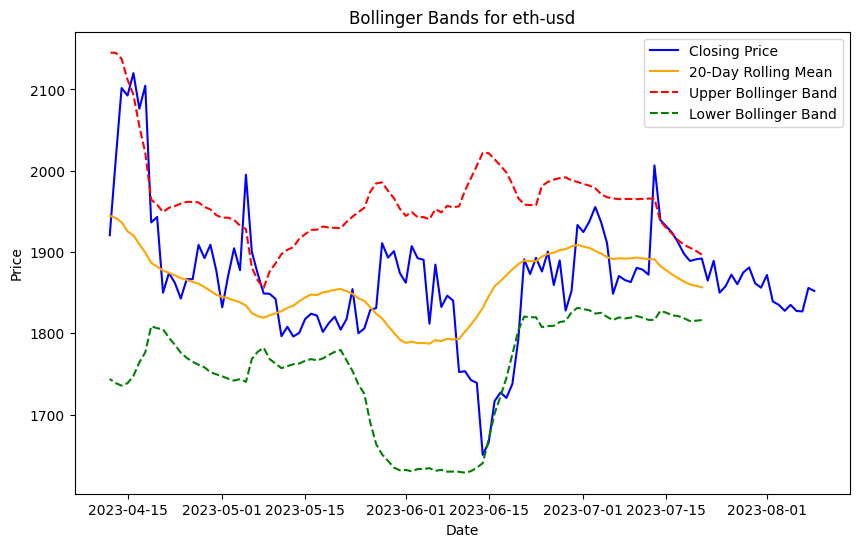

In [49]:
# Call the function to calculate and plot Bollinger Bands
calculate_bollinger_bands(df, selected_book=filtered_book, window=specify_window, num_std=2, date=filtered_date, periods=filtered_periods)

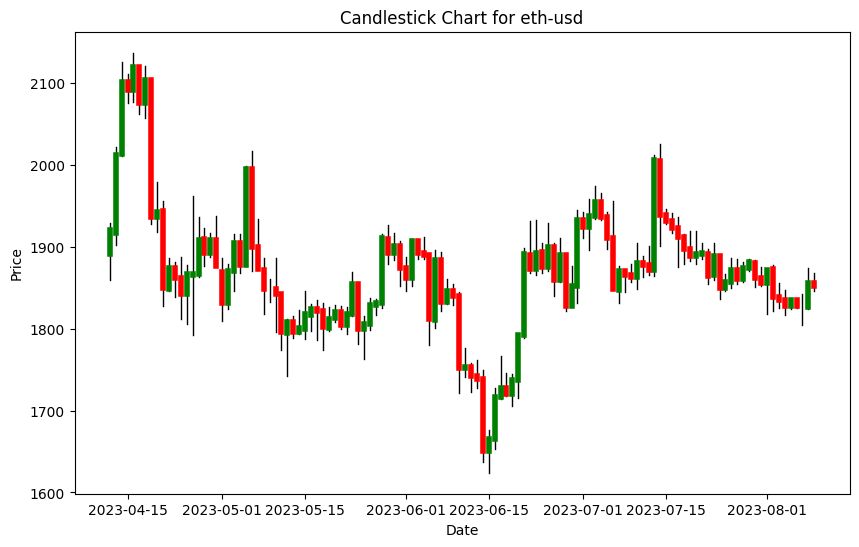

In [50]:
# Call the function with optional arguments
filtered_book = selected_book
filtered_date = '2023-01-01'
filtered_periods = 120
plot_candlesticks_manual(df, selected_book=filtered_book, date=filtered_date, periods=filtered_periods)

In [51]:
class FinancialLibrary:
    def __init__(self, InitiatedVolume=1, SellInitiatedVolume=1):
        self.InitiatedVolume = InitiatedVolume
        self.SellInitiatedVolume = SellInitiatedVolume
    
    def calculate_imbalance(self):
        """
        Calculate the financial imbalance as 'Buy Initiated Volume - Sell Initiated Volume'. 

        Returns:
            float: Financial imbalance.
        """
        return self.InitiatedVolume - self.SellInitiatedVolume
    
    def calculate_pov_rate(self, customer_order_size, market_volume):
        """
        Calculate the Percentage of Volume (POV) rate.

        Args:
            customer_order_size (float): Customer order size.
            market_volume (float): Actual market volume during the trading period.

        Returns:
            float: POV rate as a percentage.
        """
        if market_volume == 0:
            return 0
        else:
            pov_rate = (customer_order_size / market_volume) * 100
            return pov_rate
    def calculate_market_volume(self, filtered_df):
        """
        Calculate the total market volume traded over the same period.

        Args:
            filtered_df (pd.DataFrame): DataFrame containing the filtered data.

        Returns:
            float: Total market volume.
        """
        if 'volume' in filtered_df.columns:
            total_volume = filtered_df['volume'].sum()
            return total_volume
        else:
            raise ValueError("The 'volume' column is missing in the filtered_df.")
    
    def get_last_n_days_data(self, dataframe, n, sort='Desc'):
        """
        Extract data corresponding to the last n days from a DataFrame.

        Args:
        dataframe (pd.DataFrame): The input DataFrame.
        n (int): Number of last days to retrieve.
        sort (str): Sorting order for the 'date' column ('Desc' or 'Asc').

        Returns:
            pd.DataFrame: A new DataFrame containing data for the last n days.
        """
        # Ensure the 'date' column is in datetime format for date comparison
        if 'date' in dataframe.columns:
            dataframe['date'] = pd.to_datetime(dataframe['date'])

        # Calculate the date n days ago from the latest date in the DataFrame
        latest_date = dataframe['date'].max()
        n_days_ago = latest_date - pd.DateOffset(days=n)

        # Filter the DataFrame to keep data for the last n days
        last_n_days_data = dataframe[dataframe['date'] >= n_days_ago]
        
        # Sort the DataFrame by date
        if sort == 'Desc':
            last_n_days_data = last_n_days_data.sort_values(by='date', ascending=False)
        elif sort == 'Asc':
            last_n_days_data = last_n_days_data.sort_values(by='date', ascending=True)
        else:
            raise ValueError("Invalid value for 'sort'. Use 'Desc' or 'Asc'.")


        return last_n_days_data

    def calculate_financial_turnover(self, dataframe):
        """
        Calculate the financial turnover based on the given DataFrame.

        Args:
            dataframe (pd.DataFrame): The DataFrame containing financial data.

        Returns:
            float: The financial turnover.
        """
        if 'close' in dataframe.columns and 'volume' in dataframe.columns:
            financial_turnover = (dataframe['close'] * dataframe['volume']).sum()
            return financial_turnover
        else:
            raise ValueError("The 'close' and 'volume' columns are required in the DataFrame.")
            
    def calculate_vwap(self, dataframe):
        """
        Calculate the Volume-Weighted Average Price (VWAP) based on the given DataFrame.

        Args:
            dataframe (pd.DataFrame): The DataFrame containing price and volume data.

        Returns:
            float: The VWAP.
        """
        if 'close' in dataframe.columns and 'volume' in dataframe.columns:
            weighted_sum = (dataframe['close'] * dataframe['volume']).sum()
            total_volume = dataframe['volume'].sum()
            vwap = weighted_sum / total_volume
            return vwap
        else:
            raise ValueError("The 'close' and 'volume' columns are required in the DataFrame.")

    def calculate_first_price(self, dataframe):
        """
        Calculate the first price (P0) as the midpoint of the bid-ask spread at the beginning of the trading interval.

        Args:
            dataframe (pd.DataFrame): The DataFrame containing 'bid' and 'ask' columns.

        Returns:
            float: The first price (P0).
        """
        if 'bid' in dataframe.columns and 'ask' in dataframe.columns:
            # Assuming the first row represents the beginning of the trading interval
            first_bid = dataframe['bid'].iloc[0]
            first_ask = dataframe['ask'].iloc[0]
            first_price = (first_bid + first_ask) / 2
            return first_price
        else:
            raise ValueError("Both 'bid' and 'ask' columns are required in the DataFrame.")
        
    def calculate_adv(self, dataframe, T):
        """
        Calculate the Average Daily Traded Volume (ADV) based on the given DataFrame.

        Args:
            dataframe (pd.DataFrame): The DataFrame containing volume data.

        Returns:
            float: The ADV.
        """
        if 'volume' in dataframe.columns:
            total_volume = dataframe['volume'].sum()
            num_trading_days = T
            adv = total_volume / num_trading_days
            return adv
        else:
            raise ValueError("The 'volume' column is required in the DataFrame.")

    def calculate_annualized_volatility(self, dataframe):
        """
        Calculate the Annualized Volatility based on the given DataFrame.

        Args:
            dataframe (pd.DataFrame): The DataFrame containing price data.

        Returns:
            float: The annualized volatility.
        """
        if 'close' in dataframe.columns:
            # Calculate daily returns
            dataframe['return'] = dataframe['close'].pct_change()

            # Calculate the annualized volatility
            volatility = dataframe['return'].std() * np.sqrt(252)  # Assuming 252 trading days in a year

            return volatility
        else:
            raise ValueError("The 'close' column is required in the DataFrame.")

    def calculate_size(self, q, adv):
        """
        Calculate the imbalance size expressed as a percentage of ADV.

        Args:
            q: The Imbalance.

        Returns:
            float: The imbalance size expressed as a percentage of ADV.
        """
        return q/adv * 100
    
    def calculate_pov(self, q, v):
        """
        Calculate the POV rate is computed from imbalance and period volume.

        Args:
            q: The Imbalance.
            v: The period volume v(t)

        Returns:
            float: The POV rate expressed as a decimal
        """
        return q/v
    
    def calculate_cost(self, dataframe, arrival_price=None, side=1):
        """
        Calculate the cost as the logarithmic price change between the average execution price (VWAP) and the arrival price.

        Args:
            dataframe (pd.DataFrame): The DataFrame containing 'close' and 'volume' columns.
            arrival_price (float, optional): The arrival price. If not provided, it will be calculated as the VWAP.
            side (int): The trading side 1 for buying, -1 for selling.

        Returns:
            float: The cost.
        """
        if 'close' in dataframe.columns and 'volume' in dataframe.columns:
            if arrival_price is None:
                # Calculate VWAP as the average execution price
                dataframe['weighted_price'] = dataframe['close'] * dataframe['volume']
                vwap = dataframe['weighted_price'].sum() / dataframe['volume'].sum()
                arrival_price = vwap

            # Calculate the cost as the logarithmic price change
            cost = np.log(arrival_price / dataframe['close'].iloc[0])#*side*(10**4)
            return cost
        else:
            raise ValueError("Both 'close' and 'volume' columns are required in the DataFrame.")

    
    def calculate_istar_cost(self, dataframe, strategy_volume, strategy_price, execution_volume, execution_price, arrival_price=None):
        """
        Calculate the cost of executing a trade using the I-Star model.

        Args:
            dataframe (pd.DataFrame): The DataFrame containing 'close' and 'volume' columns.
            strategy_volume (float): The planned trading volume.
            strategy_price (float): The target price for the trade.
            execution_volume (float): The executed trading volume.
            execution_price (float): The execution price.
            arrival_price (float, optional): The arrival price. If not provided, it will be calculated as the VWAP.

        Returns:
            float: The estimated cost using the I-Star model.
        """
        if 'close' in dataframe.columns and 'volume' in dataframe.columns:
            if arrival_price is None:
                # Calculate VWAP as the average execution price
                dataframe['weighted_price'] = dataframe['close'] * dataframe['volume']
                vwap = dataframe['weighted_price'].sum() / dataframe['volume'].sum()
                arrival_price = vwap

            # Calculate the arrival cost
            arrival_cost = np.abs(execution_volume) * (arrival_price - execution_price)

            # Calculate the market impact cost (price change cost)
            market_impact_cost = np.abs(strategy_volume) * (strategy_price - arrival_price)

            # Calculate the total cost
            total_cost = arrival_cost + market_impact_cost
            return total_cost
        else:
            raise ValueError("Both 'close' and 'volume' columns are required in the DataFrame.")

    def calculate_market_impact_cost(self, dataframe, execution_volume, impact_parameter=0.01, arrival_price=None):
        """
        Calculate the cost of executing a trade using the Market Impact model.

        Args:
            dataframe (pd.DataFrame): The DataFrame containing 'close' and 'volume' columns.
            execution_volume (float): The executed trading volume.
            impact_parameter (float, optional): The market impact parameter (constant).
            arrival_price (float, optional): The arrival price. If not provided, it will be calculated as the VWAP.

        Returns:
            float: The estimated cost using the Market Impact model.
        """
        if 'close' in dataframe.columns and 'volume' in dataframe.columns:
            if arrival_price is None:
                # Calculate VWAP as the average execution price
                dataframe['weighted_price'] = dataframe['close'] * dataframe['volume']
                vwap = dataframe['weighted_price'].sum() / dataframe['volume'].sum()
                arrival_price = vwap

            # Calculate the market impact cost
            market_impact_cost = impact_parameter * execution_volume * (arrival_price - dataframe['close'].iloc[0])

            return market_impact_cost
        else:
            raise ValueError("Both 'close' and 'volume' columns are required in the DataFrame.")

    def filter_dataframe_by_volume(dataframe, adv):
        """
        Filter a DataFrame based on the condition 'Daily volume <= 3 * ADV'.

        Args:
            dataframe (pd.DataFrame): The DataFrame containing 'volume' column.
            adv (float): The Average Daily Traded Volume (ADV).

        Returns:
            pd.DataFrame: Filtered DataFrame.
        """
        return dataframe[dataframe['volume'] <= 3 * adv]

    def filter_dataframe_by_log_price_change(dataframe):
        """
        Filter a DataFrame based on the condition '-4*[daily_volatility/sqrt(255)] <= Log price change (close-to-close) <= 4*[daily_volatility/sqrt(255)]'.

        Args:
            dataframe (pd.DataFrame): The DataFrame containing 'close' column.

        Returns:
            pd.DataFrame: Filtered DataFrame.
        """
        # Calculate daily returns
        dataframe['return'] = dataframe['close'].pct_change()

        # Calculate daily volatility
        daily_volatility = dataframe['return'].std()

        # Define the filter condition
        lower_bound = -4 * (daily_volatility / np.sqrt(255))
        upper_bound = 4 * (daily_volatility / np.sqrt(255))

        return dataframe[(dataframe['return'] >= lower_bound) & (dataframe['return'] <= upper_bound)]
    
    class MarketImpactModel:
        def __init__(self, a1=100, a2=0.1, a3=0.1, a4=0.1, b1=0.75):
            # Initialize the model parameters
            self.a1 = a1
            self.a2 = a2
            self.a3 = a3
            self.a4 = a4
            self.b1 = b1

        def calculate_cost(self, size, volatility, pov):
            """
                Calculate the cost of executing a trade using the Market Impact model based on the provided formula.

                Args:
                    size (float): The executed trading size (volume).
                    volatility (float): Volatility of the asset.
                    a1 (float): Model parameter a1.
                    a2 (float): Model parameter a2.
                    a3 (float): Model parameter a3.
                    a4 (float): Model parameter a4.
                    b1 (float): Model parameter b1.
                    pov (float): Percentage of volume (POV).

                Returns:
                    float: The estimated cost using the Market Impact model.
            """
            I = self.a1 * size ** self.a2 * (volatility) ** self.a3
            market_impact_cost = self.b1 * I * (pov ** self.a4) + (1 - self.b1) * I
            return market_impact_cost

        def set_parameters(self, a1=None, a2=None, a3=None, a4=None, b1=None):
            # Set model parameters
            if a1 is not None:
                self.a1 = a1
            if a2 is not None:
                self.a2 = a2
            if a3 is not None:
                self.a3 = a3
            if a4 is not None:
                self.a4 = a4
            if b1 is not None:
                self.b1 = b1

        def estimate_parameters(self, data, size, pov):
            # Define the cost function to be minimized during parameter estimation
            '''
            def cost_function(parameters):
                self.set_parameters(*parameters)
                total_cost = 0
                for _, row in data.iterrows():
                    size = row['size']
                    volatility = row['volatility']
                    pov = row['pov']
                    cost = row['cost']
                    estimated_cost = self.calculate_cost(size, volatility, pov)
                    total_cost += (cost - estimated_cost) ** 2
                return total_cost
            '''
            def cost_function(x, a1, a2, a3, a4, b1):
                self.set_parameters(a1, a2, a3, a4, b1)
                total_cost = 0
                '''
                for _, row in data.iterrows():
                    size = row['size']
                    volatility = row['volatility']
                    pov = row['pov']
                    cost = row['cost']
                    estimated_cost = self.calculate_cost(size, volatility, pov)
                    #total_cost += (cost - estimated_cost) ** 2
                    #print("total_cost: ", total_cost, "; estimated_cost: ", estimated_cost)
                return estimated_cost'''
                size, volatility, pov = x
                estimated_cost = self.calculate_cost(size, volatility, pov)
                total_cost += (cost - estimated_cost) ** 2
                return total_cost
            
            # Extract xdata and ydata from the DataFrame
            xdata = data[['size', 'volatility', 'pov']].values.T
            ydata = data['cost'].values

            # Fit the parameters using non-linear least squares
            initial_parameters = [self.a1, self.a2, self.a3, self.a4, self.b1]
            optimized_parameters, _ = curve_fit(cost_function, xdata, ydata, p0=initial_parameters, method='lm', maxfev=1200)

            self.set_parameters(*optimized_parameters)

        def sensitivity_analysis(self, data, size, pov, parameter, values_to_test, perform_full_regression=False):
            results = []

            # Store original parameter value
            original_value = getattr(self, parameter)

            if not perform_full_regression:
                for value in values_to_test:
                    setattr(self, parameter, value)
                    print(f"parameter {parameter}: {value}")
                    # Estimate parameters with the modified value
                    self.estimate_parameters(data, size, pov)

                    # Record the resulting parameter values and R-squared estimate
                    optimized_parameters = [self.a1, self.a2, self.a3, self.a4, self.b1]
                    r_squared = self.calculate_r_squared(data, size, pov)
                    results.append((optimized_parameters, r_squared))
            else:
                # Perform the full nonlinear least squares regression
                self.estimate_parameters(data, size, pov)

                # Record the resulting parameter values and R-squared estimate
                optimized_parameters = [self.a1, self.a2, self.a3, self.a4, self.b1]
                r_squared = self.calculate_r_squared(data, size, pov)

                results.append((optimized_parameters, r_squared))

            # Restore the original parameter value
            setattr(self, parameter, original_value)

            return results

        def calculate_r_squared(self, data, size, pov):
            total_cost = 0
            for _, row in data.iterrows():
                size = row['size']
                volatility = row['volatility']
                pov = row['pov']
                cost = row['cost']
                estimated_cost = self.calculate_cost(size, volatility, pov)
                total_cost += (cost - estimated_cost) ** 2

            y_variance = sum((data['cost'] - data['cost'].mean()) ** 2)
            r_squared = 1 - (total_cost / y_variance)

            return r_squared

        def plot_sensitivity_results(self, parameter_name, parameter_values, r_squared_values):
            plt.figure(figsize=(10, 6))
            plt.plot(parameter_values, r_squared_values, marker='o')
            plt.xlabel(parameter_name)
            plt.ylabel("Nonlinear R-squared")
            plt.title(f"Sensitivity Analysis for {parameter_name}")
            plt.grid(True)
            plt.show()
            
    def calculate_market_impact_cost(self, data, size, volatility, pov):
        model = self.MarketImpactModel()
        return model.calculate_cost(size, volatility, pov)
    
    def run_sensitivity_analysis(self, model, data, size, pov, parameters_to_analyze, values_to_test, perform_full_regression=False):
        for parameter in parameters_to_analyze:
            
            # Perform sensitivity analysis for the specified parameter
            results = model.sensitivity_analysis(data, size, pov, parameter, values_to_test[parameter], perform_full_regression)
            
            # Extract parameter values and R-squared values from the results
            parameter_values, r_squared_values = zip(*results)
            print("parameter_values: ", parameter_values, "r_squared_values: ", r_squared_values)
            
            # Call the plot_sensitivity_results method to visualize the results
            model.plot_sensitivity_results(parameter, parameter_values, r_squared_values)

In [ ]:
class FinancialAnalysis():
    
    def pcaWeights(cov, riskDist=None, riskTarget=1.):
        # Following the riskAlloc distribution, match riskTarget
        eVal, eVec=np.eigh(cov) # must be Hermitian
        indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
        eVal, eVec=eVal[indices],eVec[:,indices]
        if riskDist is None:
            riskDist=np-zeros(cov.shape[0])
            riskDist[-1]=1.
        loads=riskTarget*(riskDist/eVal)**.5
        wghts=np.dot(eVec,np.reshape(loads, (-1,1)))
        #ctr=(loads/riskTarget)**2*eVal # verify riskDist
        return wghts

In [52]:
# Create an instance of the FinancialLibrary class
#finance = FinancialLibrary()

In [62]:
T=1

In [77]:
# Sort the DataFrame by 'date' in descending order
df_sorted = df.sort_values(by='date', ascending=False)

# Drop duplicates, keeping only the first occurrence for each unique combination of book and date
df_unique_latest = df_sorted.drop_duplicates(subset=['book', 'date'])

filtered_df_by_book = df_unique_latest[df_unique_latest['book'] == selected_book]
last_n_days_data = finance.get_last_n_days_data(filtered_df_by_book, n=T, sort='Desc')
print("Last n days data in descending order:")
print(last_n_days_data.head())

Last n days data in descending order:
                             ref     book       date     open     high  \
75559  https://finance.yahoo.com  eth-usd 2024-04-19  3066.03  3119.11   
75456  https://finance.yahoo.com  eth-usd 2024-04-18  2985.43  3086.07   
75560  https://finance.yahoo.com  eth-usd 2024-04-18  2984.71  3094.84   

           low    close  adj_close       volume  
75559  2878.13  3049.42    3049.42  19457873920  
75456  2960.91  3082.04    3082.04  18573953024  
75560  2956.13  3066.03    3066.03  15183777035  


/var/folders/07/gh2gmtpn6lv4r8x2y_vd7ccm0000gn/T/ipykernel_1627/309268447.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['date'] = pd.to_datetime(dataframe['date'])


In [64]:
market_volume = finance.calculate_market_volume(last_n_days_data)
print(f"Total Market Volume: {market_volume}")

Total Market Volume: 53215603979


In [65]:
financial_turnover = finance.calculate_financial_turnover(last_n_days_data)
print(f"Financial Turnover: {financial_turnover}")

Financial Turnover: 163134811969836.4


In [66]:
vwap = finance.calculate_vwap(last_n_days_data)
print(f"Volume-Weighted Average Price (VWAP): {vwap}")

Volume-Weighted Average Price (VWAP): 3065.544685619144


In [67]:
adv = finance.calculate_adv(last_n_days_data, T)
print(f"Average Daily Traded Volume (ADV): {adv}")

Average Daily Traded Volume (ADV): 53215603979.0


In [68]:
annualized_volatility = finance.calculate_annualized_volatility(last_n_days_data)    
print(f"Annualized Volatility: {annualized_volatility}")

Annualized Volatility: 0.17838419915101153


In [69]:
cost = finance.calculate_cost(last_n_days_data)
print(f"Cost (Logarithmic Price Change): {cost}")

Cost (Logarithmic Price Change): 0.005273856456045542


parameter a1: 100.0
parameter a1: 200.0
parameter a1: 300.0
parameter a1: 400.0
parameter a1: 500.0
parameter a1: 600.0
parameter a1: 700.0
parameter a1: 800.0
parameter a1: 900.0
parameter a1: 1000.0
parameter_values:  ([33.31120255144352, 0.007703370168627571, -0.4455150012516132, 0.9421969463106747, 0.9328452586624197], [33.311237476130415, 0.007704497320149104, -0.44551729865407663, 0.9421979788767865, 0.9328452300520179], [33.3112542890182, 0.007705039828250354, -0.4455184020733162, 0.9421984740495846, 0.932845215991828], [33.31120836797134, 0.00770355785312458, -0.44551538298667526, 0.9421971176208274, 0.9328452537975046], [33.31122537195685, 0.0077041067791608474, -0.445516504932009, 0.9421976228777237, 0.9328452402491613], [33.3112426675781, 0.007704665400097434, -0.44551765311811686, 0.9421981420318515, 0.9328452272578349], [33.31124175049555, 0.00770463546676241, -0.4455175846330357, 0.942198108836046, 0.9328452270904928], [33.31125710933067, 0.00770513013900009, -0.445518570

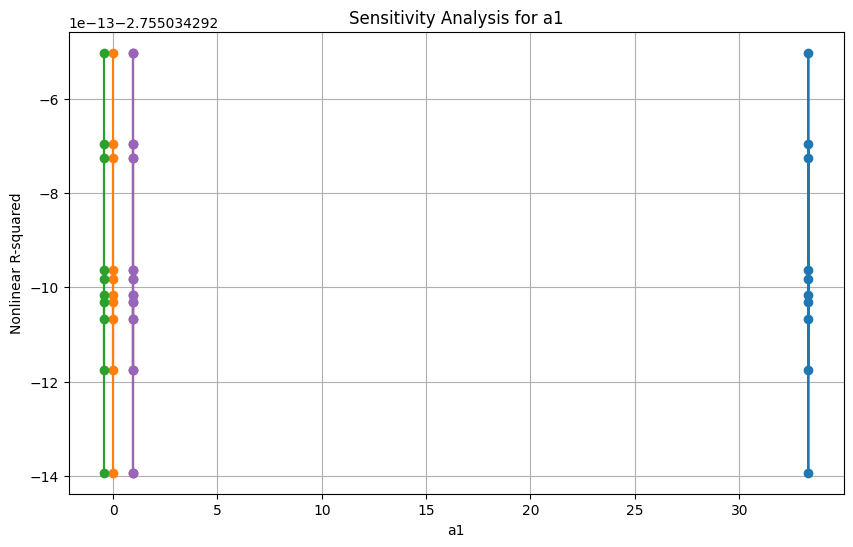

parameter a2: 0.1
parameter a2: 0.2
parameter a2: 0.30000000000000004
parameter a2: 0.4
parameter a2: 0.5
parameter a2: 0.6
parameter a2: 0.7000000000000001
parameter a2: 0.8
parameter a2: 0.9
parameter a2: 1.0


/var/folders/07/gh2gmtpn6lv4r8x2y_vd7ccm0000gn/T/ipykernel_1627/309268447.py:393: RuntimeWarning: overflow encountered in square
  total_cost += (cost - estimated_cost) ** 2
/var/folders/07/gh2gmtpn6lv4r8x2y_vd7ccm0000gn/T/ipykernel_1627/309268447.py:393: RuntimeWarning: overflow encountered in square
  total_cost += (cost - estimated_cost) ** 2
/var/folders/07/gh2gmtpn6lv4r8x2y_vd7ccm0000gn/T/ipykernel_1627/309268447.py:346: RuntimeWarning: overflow encountered in multiply
  I = self.a1 * size ** self.a2 * (volatility) ** self.a3
/var/folders/07/gh2gmtpn6lv4r8x2y_vd7ccm0000gn/T/ipykernel_1627/309268447.py:347: RuntimeWarning: invalid value encountered in multiply
  market_impact_cost = self.b1 * I * (pov ** self.a4) + (1 - self.b1) * I
/var/folders/07/gh2gmtpn6lv4r8x2y_vd7ccm0000gn/T/ipykernel_1627/309268447.py:393: RuntimeWarning: overflow encountered in square
  total_cost += (cost - estimated_cost) ** 2
/var/folders/07/gh2gmtpn6lv4r8x2y_vd7ccm0000gn/T/ipykernel_1627/309268447.py:34

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

In [70]:
# Create a sample DataFrame for sensitivity analysis (replace with your data)
test_data = pd.DataFrame({
    'size': np.linspace(0.005, 0.3, 10),
    'volatility': np.linspace(0.1, 0.8, 10),
    'pov': np.linspace(0.01, 0.8, 10),
    'cost': np.linspace(50, 900, 10)
})

# Create an instance of the MarketImpactModel
model = finance.MarketImpactModel()

# Specify the parameter to analyze (e.g., 'a1')
parameters_to_analyze = ['a1','a2','a3','a4','b1']

# Define a range of values to test for the parameter
'''values_to_test = {
    'a1': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'a2': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'a3': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'a4': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'b1': [0.75, 0.80, 0.85, 0.90, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0],
}
'''
values_to_test = {
    'a1': np.linspace(100, 1000, 10),
    'a2': np.linspace(0.1, 1.0, 10),
    'a3': np.linspace(0.1, 1.0, 10),
    'a4': np.linspace(0.1, 1.0, 10),
    'b1': np.linspace(0.75, 1.0, 10),
}

# Perform sensitivity analysis without full regression
finance.run_sensitivity_analysis(
    model, 
    test_data, 
    1000, 
    0.1, 
    parameters_to_analyze, 
    values_to_test
)

# Perform full regression without varying parameters
finance.run_sensitivity_analysis(
    model,
    test_data,
    1000,
    0.1,
    parameters_to_analyze,
    values_to_test,
    perform_full_regression=True
)